In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
#from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from imblearn.under_sampling import *
import warnings
warnings.filterwarnings("ignore")

## 분석 목표

- 신용카드 사기 데이터를 바탕으로 거래가 정상적인 결제인지 사기인지 탐지(분류)하는 다양한 예측 모델 수립
- 토픽 : 불균형한 데이터셋을 어떻게 처리할 것인가

## EDA

In [2]:
df = pd.read_csv("C:/Users/hyelim/Desktop/creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
#개인 정보 보호로 인해 거래금액과 시간을 제외하고는 변수를 알 수 없음
#v1~v28 은 이미 pca 변환을 거침 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
#결측치 확인
df.isna().sum().max()

0

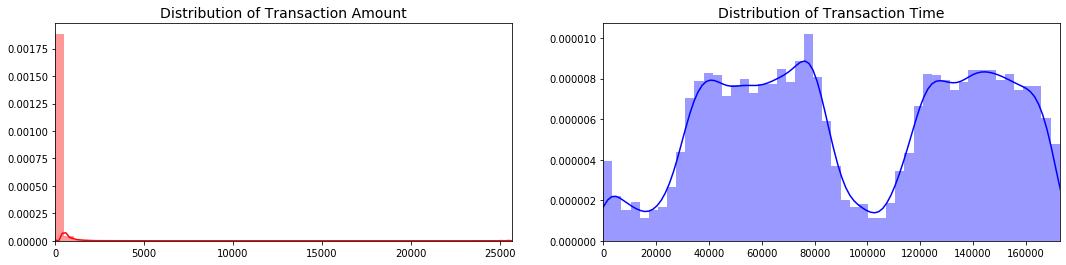

In [7]:
# time와 amount 데이터 분포 살펴보기

fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

#amount는 0에 쏠려있음
#time는 0~16만이 넘는 값에 분포
#둘 다 데이터 분포가 너무 크다

## 정규화

In [8]:
#amount에 대한 정규화 
scaler = StandardScaler()
df['scaler_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))

rob_scaler = RobustScaler()
df['rob_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

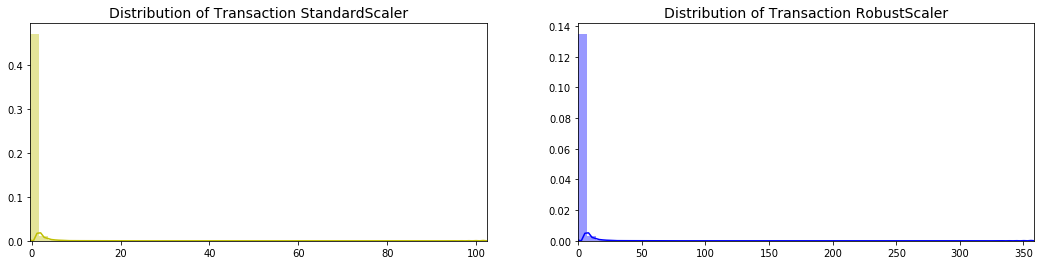

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

scaler_amount = df['scaler_amount'].values
rob_amount = df['rob_amount'].values


sns.distplot(scaler_amount, ax=ax[0], color='y')
ax[0].set_title('Distribution of Transaction StandardScaler', fontsize=14)
ax[0].set_xlim([min(scaler_amount), max(scaler_amount)])

sns.distplot(rob_amount, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction RobustScaler', fontsize=14)
ax[1].set_xlim([min(rob_amount), max(rob_amount)])

plt.show()

#StandardScaler 채택

In [10]:
#time에 대한 정규화
scaler = StandardScaler()
df['scaler_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

rob_scaler = RobustScaler()
df['rob_Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

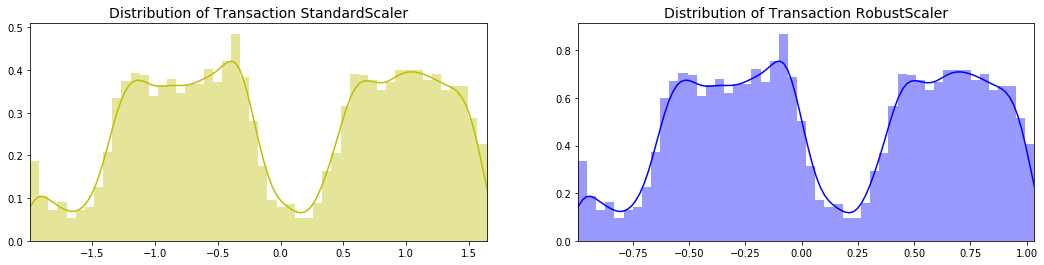

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

scaler_Time = df['scaler_Time'].values
rob_Time = df['rob_Time'].values

sns.distplot(scaler_Time, ax=ax[0], color='y')
ax[0].set_title('Distribution of Transaction StandardScaler', fontsize=14)
ax[0].set_xlim([min(scaler_Time), max(scaler_Time)])

sns.distplot(rob_Time, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction RobustScaler', fontsize=14)
ax[1].set_xlim([min(rob_Time), max(rob_Time)])

plt.show()

#RobustScaler 채택

In [12]:
#정규화된 데이터 추가
df.drop(['Amount','Time','rob_amount','scaler_Time'],axis=1,inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   V1             284807 non-null  float64
 1   V2             284807 non-null  float64
 2   V3             284807 non-null  float64
 3   V4             284807 non-null  float64
 4   V5             284807 non-null  float64
 5   V6             284807 non-null  float64
 6   V7             284807 non-null  float64
 7   V8             284807 non-null  float64
 8   V9             284807 non-null  float64
 9   V10            284807 non-null  float64
 10  V11            284807 non-null  float64
 11  V12            284807 non-null  float64
 12  V13            284807 non-null  float64
 13  V14            284807 non-null  float64
 14  V15            284807 non-null  float64
 15  V16            284807 non-null  float64
 16  V17            284807 non-null  float64
 17  V18            284807 non-nul

## 이상치 처리

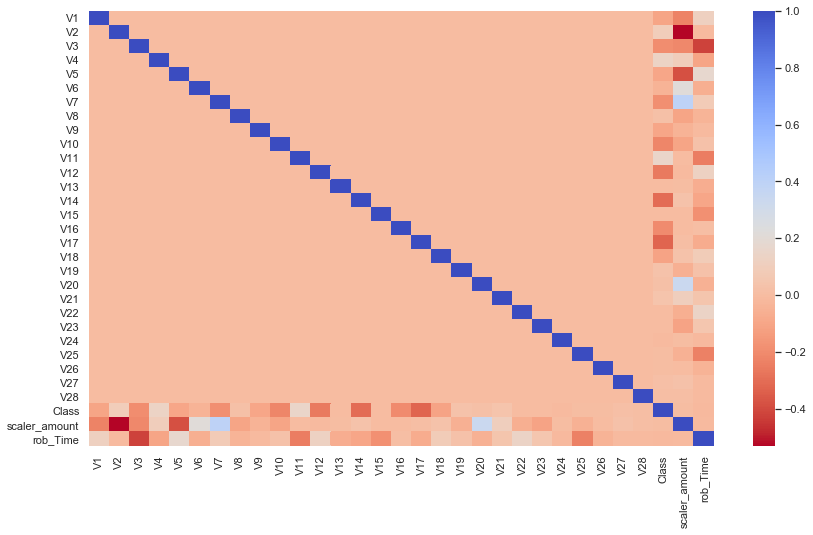

In [14]:
#상관관계를 확인 후 목표변수에 영향을 많이 미치는 컬럼에서 이상치 제거

sns.set(rc={'figure.figsize':(14,8)})
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r')

In [15]:
#상관관계 수치로 확인
# 종속변수('Class')와의 상관관계
Corr = df.corr()
IF = Corr['Class'].sort_values().to_frame()
IF.head(5)

,Class
V17,-0.326481
V14,-0.302544
V12,-0.260593
V10,-0.216883
V16,-0.196539


Text(0.5, 1.0, 'Boxplot of V17')

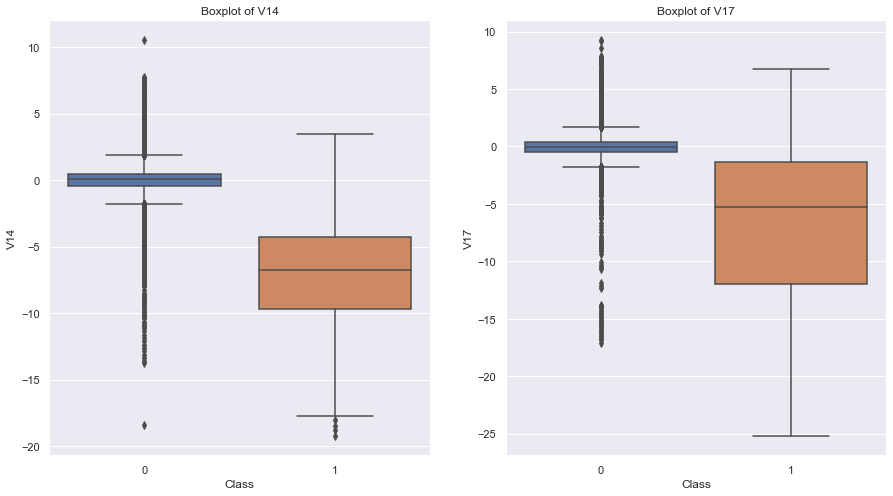

In [16]:
#V14, V17의 상자 그림
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(x=df['Class'], y=df["V14"],data=df, ax=ax[0])
ax[0].set_title("Boxplot of V14")

sns.boxplot(x=df['Class'], y=df["V17"],data=df,ax=ax[1])
ax[1].set_title("Boxplot of V17")

Text(0.5, 1.0, 'Boxplot of V23')

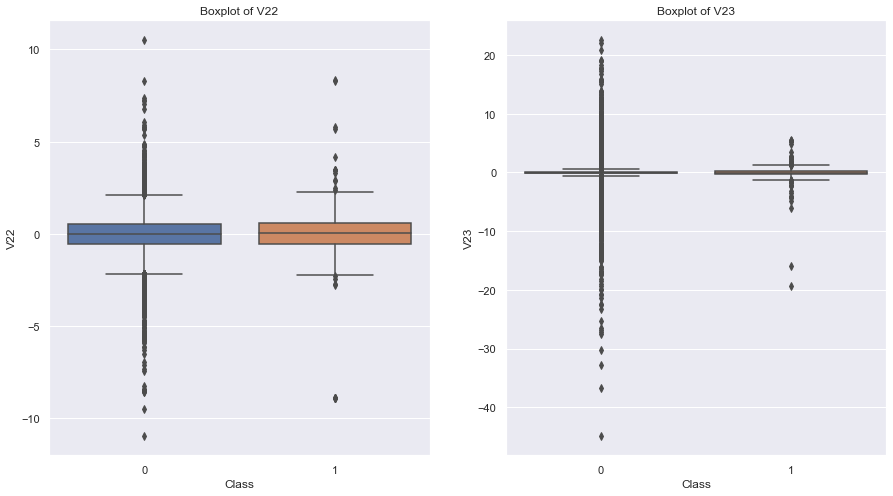

In [17]:
#V22와 V23의 상자그림을 비교 
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(x=df['Class'], y=df["V22"],data=df, ax=ax[0])
ax[0].set_title("Boxplot of V22")

sns.boxplot(x=df['Class'], y=df["V23"],data=df,ax=ax[1])
ax[1].set_title("Boxplot of V23")

In [18]:
#14, 17의 이상치 제거
def remove_outlier(d_cp, column):
    fraud_column_data = d_cp[d_cp['Class']==0][column]
    quan_25 = np.percentile(fraud_column_data.values,25)
    quan_75 = np.percentile(fraud_column_data.values,75)
    
    iqr = quan_75-quan_25
    iqr = iqr*1.5
    lowest = quan_25 - iqr
    highest = quan_75 + iqr
    outlier_index = fraud_column_data[(fraud_column_data < lowest) | (fraud_column_data > highest)].index
    print(len(outlier_index))
    d_cp.drop(outlier_index, axis = 0, inplace = True)
    print(d_cp.shape)
    return d_cp

In [19]:
df = remove_outlier(df, 'V14')
df = remove_outlier(df, 'V17')

13800
(271007, 31)
3578
(267429, 31)


Text(0.5, 1.0, 'Boxplot of V17')

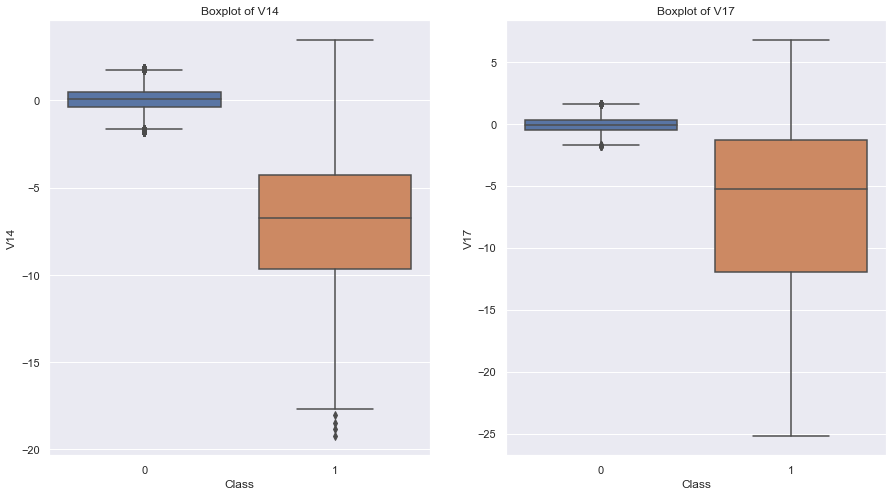

In [20]:
#이상치가 제거된 V14, V17의 상자 그림
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(x=df['Class'], y=df["V14"],data=df, ax=ax[0])
ax[0].set_title("Boxplot of V14")

sns.boxplot(x=df['Class'], y=df["V17"],data=df,ax=ax[1])
ax[1].set_title("Boxplot of V17")

In [21]:
df_copy = df.copy()

## 불균형한 데이터 처리

- 언더 샘플링 : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소 시키는 방법

- 오버 샘플링 : 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법

In [22]:
# 목표 변수의 분포 확인
df['Class'].value_counts()

0    266937
1       492
Name: Class, dtype: int64

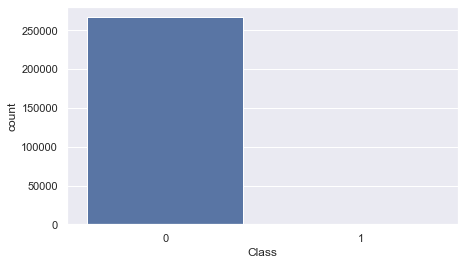

In [23]:
# 목표 변수의 분포 확인
sns.set(rc={'figure.figsize':(7,4)})
sns.countplot(x='Class',data=df)

#문제점 : 매우 불균형함

## 과적합을 방지하기 위한 작업

In [24]:
#훈련, 테스트 데이터 나누기(8:2)
X=df.drop(['Class'],axis=1)
y=df['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=11,shuffle=True)

print(X_train.shape)
print(X_test.shape)

(213943, 30)
(53486, 30)


In [25]:
#X_samp, y_samp = RandomUnderSampler(random_state=0).fit_sample(X_imb, y_imb)
rus = RandomUnderSampler(random_state=0)
X_train_under,y_train_under = rus.fit_sample(X_train,y_train)
print('RandomUnder 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('RandomUnder 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_under.shape, y_train_under.shape)
print('RandomUnder 적용 후 레이블 값 분포:\n', pd.Series(y_train_under).value_counts())

RandomUnder 적용 전 학습용 피처/레이블 데이터 세트:  (213943, 30) (213943,)
RandomUnder 적용 후 학습용 피처/레이블 데이터 세트:  (774, 30) (774,)
RandomUnder 적용 후 레이블 값 분포:
 1    387
0    387
Name: Class, dtype: int64


In [26]:
dt = pd.concat([X_train_under,y_train_under],axis=1)
df_under = dt.sample(len(dt)).reset_index(drop=True)
df_under

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,scaler_amount,rob_Time,Class
0,1.155629,-0.307500,1.105649,0.685864,-0.979439,0.175827,-0.805439,0.301779,0.860971,-0.039389,...,-0.108959,-0.010896,0.008906,0.229295,0.323289,0.005010,0.011782,-0.307251,-0.624126,0
1,1.226937,0.100960,-0.168917,0.798603,0.660623,1.103372,-0.141816,0.269774,0.100341,0.077408,...,-0.594565,-0.181556,-1.724122,0.646354,-0.378906,0.035893,-0.003930,-0.292938,-0.085704,0
2,-1.110330,0.374944,1.379602,-1.678292,-1.630567,0.271700,-1.582681,1.096132,-0.839690,-0.081930,...,1.546763,-0.181595,-0.284472,-0.449561,-0.052660,-0.313229,0.015783,-0.323284,0.500793,0
3,-3.170818,0.185735,-3.399852,3.761155,-2.148047,-1.598944,-2.519565,1.316215,-2.400106,-4.993417,...,-0.041080,0.904395,0.180016,0.049970,-0.257100,0.859282,0.225924,1.351555,-0.160469,1
4,-2.003460,-7.159042,-4.050976,1.309580,-2.058102,-0.098621,2.880083,-0.727484,1.460381,-1.531608,...,-1.015232,-1.800985,0.657586,-0.435617,-0.894509,-0.397557,0.314262,8.146182,0.445447,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,1.037489,0.311462,1.099132,2.529935,-0.193429,0.678697,-0.280924,0.300594,-0.529349,0.615578,...,-0.696035,0.157573,-0.019570,0.155845,-0.264585,0.029741,0.020120,-0.292578,-0.521317,0
770,-1.179294,1.352268,0.550911,-1.359371,1.112860,-1.375839,1.536699,-0.284219,-0.344304,-1.588430,...,0.579732,-0.589660,-0.081457,1.292228,-0.150575,0.119128,0.116659,-0.288340,0.788602,0
771,1.264464,-1.355062,0.257735,-1.419330,-1.402198,-0.253333,-0.963857,0.028348,-2.076140,1.552333,...,-0.093105,-0.026900,-0.004248,0.251377,-0.196197,0.017906,0.020595,0.060573,-0.057825,0
772,-1.328513,1.695471,1.170824,3.063501,-0.036084,0.768347,-0.502803,1.081779,-2.262343,0.588736,...,0.523183,-0.327204,-0.257275,0.131594,0.478137,-0.232078,-0.119420,-0.353229,-0.570460,0


In [27]:
#훈련, 검증 데이터 나누기(8:2)
X=dt.drop(['Class'],axis=1)
y=dt['Class']

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.20,random_state=10,shuffle=True)

print(X_train.shape)
print(X_val.shape)

(619, 30)
(155, 30)


## 1. 언더 샘플링에서 모델링

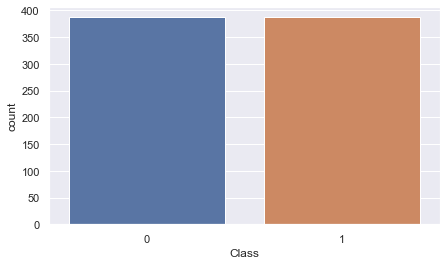

In [28]:
sns.countplot(x='Class',data=df_under)

## 모델링

- 검증 데이터(validation data)를 사용해 모델 생성

In [29]:
#모델링 함수
def modeling(model,X_train,X_val,y_train,y_val):
    model.fit(X_train,y_train)
    pred = model.predict(X_val)
    metrics(y_val,pred)

In [30]:
#정확도, 정밀도, 재현율, f1-score, auroc 확인
def metrics(y_val,pred):
    accuracy = accuracy_score(y_val,pred)
    precision = precision_score(y_val,pred)
    recall = recall_score(y_val,pred)
    f1 = f1_score(y_val,pred)
    roc_score = roc_auc_score(y_val,pred,average='macro')
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy,precision,recall))
    print('f1-score : {0:.2f}, auc : {1:.3f}'.format(f1,roc_score))

In [31]:
#로지스틱 회귀
lr = LogisticRegression(random_state = 0,C=1000)
modeling(lr,X_train,X_val,y_train,y_val)

정확도 : 0.96, 정밀도 : 0.99, 재현율 : 0.94
f1-score : 0.96, auc : 0.962


In [32]:
#랜덤 포레스트
rfc = RandomForestClassifier(n_estimators=200,random_state=300, max_depth=10,n_jobs=-1)
modeling(rfc,X_train,X_val,y_train,y_val)

정확도 : 0.97, 정밀도 : 1.00, 재현율 : 0.95
f1-score : 0.97, auc : 0.975


In [33]:
#svm
svm = SVC()
modeling(svm,X_train,X_val,y_train,y_val)

정확도 : 0.95, 정밀도 : 1.00, 재현율 : 0.90
f1-score : 0.95, auc : 0.951


In [34]:
#lgbm
lgb = LGBMClassifier(n_estimators=300,num_leaves=64,n_jobs=-1,boost_from_average=False)
modeling(lgb,X_train,X_val,y_train,y_val)

정확도 : 0.97, 정밀도 : 1.00, 재현율 : 0.94
f1-score : 0.97, auc : 0.969


### 테스트 데이터 정확도 확인

In [35]:
#로지스틱 회귀
lr = LogisticRegression()
modeling(lr,X_train,X_test,y_train,y_test)

정확도 : 0.98, 정밀도 : 0.08, 재현율 : 0.96
f1-score : 0.15, auc : 0.970


In [36]:
#랜덤 포레스트
rfc = RandomForestClassifier()
modeling(rfc,X_train,X_test,y_train,y_test)

정확도 : 0.99, 정밀도 : 0.16, 재현율 : 0.94
f1-score : 0.28, auc : 0.967


In [37]:
#xgb
xgb = XGBClassifier()
modeling(xgb,X_train,X_test,y_train,y_test)

정확도 : 0.98, 정밀도 : 0.10, 재현율 : 0.96
f1-score : 0.18, auc : 0.972


In [38]:
#lgbm
lgb = LGBMClassifier(n_estimators=300,num_leaves=64,n_jobs=-1,boost_from_average=False)
modeling(lgb,X_train,X_test,y_train,y_test)

정확도 : 0.99, 정밀도 : 0.12, 재현율 : 0.95
f1-score : 0.21, auc : 0.969


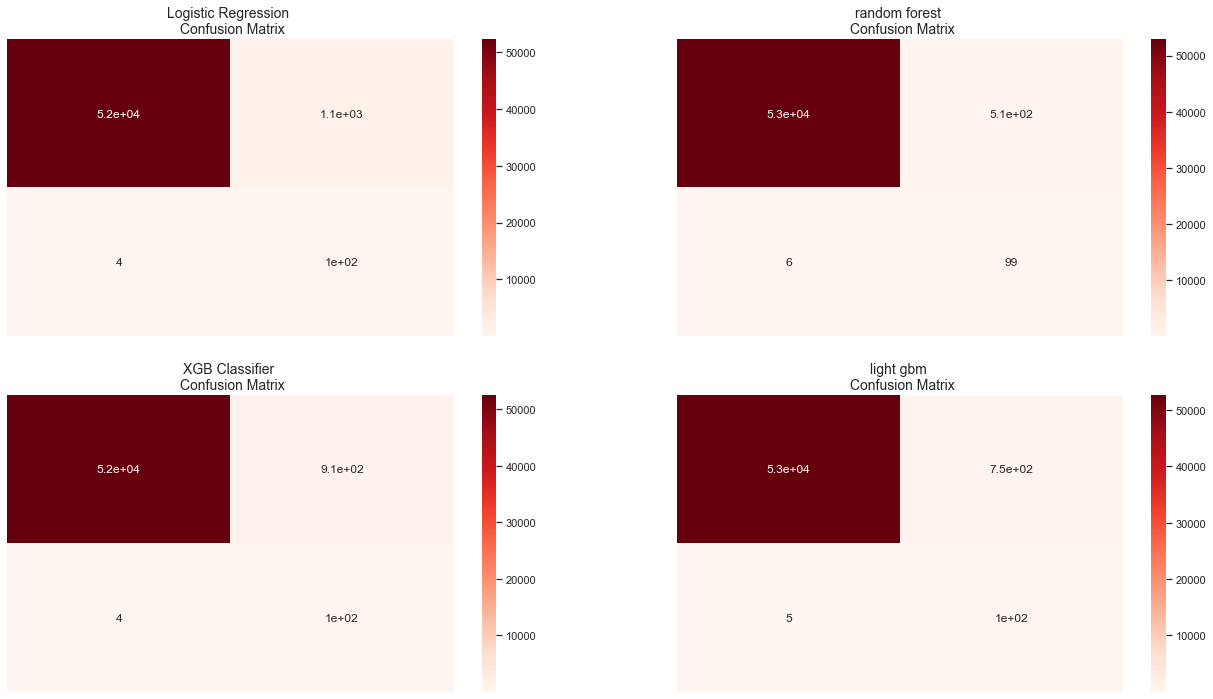

In [39]:
#히트맵 그리기
y_pred_log_reg = lr.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_lgb = lgb.predict(X_test)


lr = confusion_matrix(y_test, y_pred_log_reg)
rfc = confusion_matrix(y_test, y_pred_rfc)
xgb = confusion_matrix(y_test, y_pred_xgb)
lgb = confusion_matrix(y_test, y_pred_lgb)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(lr, ax=ax[0][0], annot=True, cmap=plt.cm.Reds)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=30, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=30, rotation=360)

sns.heatmap(rfc, ax=ax[0][1], annot=True, cmap=plt.cm.Reds)
ax[0][1].set_title("random forest \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=30, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=30, rotation=360)

sns.heatmap(xgb, ax=ax[1][0], annot=True, cmap=plt.cm.Reds)
ax[1][0].set_title("XGB Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=30, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=30, rotation=360)

sns.heatmap(lgb, ax=ax[1][1], annot=True, cmap=plt.cm.Reds)
ax[1][1].set_title("light gbm \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=30, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=30, rotation=360)

plt.show()

## 언더 샘플링 신경망

In [40]:
#언더 샘플링에서 ANN
import keras
from keras import backend as K
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import binary_crossentropy
from keras.models import *
from keras.layers import *


model = Sequential()
model.add(Dense(12, input_shape=(30, ), activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))
optimizer = Adam()
model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                372       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [42]:
history=model.fit(X_train,y_train,epochs=10,batch_size=5,validation_data=(X_val,y_val))

Epoch 1/10
124/124 [==============================] - 1s 10ms/step - loss: 0.5840 - accuracy: 0.5832 - val_loss: 0.4327 - val_accuracy: 0.6968
Epoch 2/10
124/124 [==============================] - 1s 5ms/step - loss: 0.4548 - accuracy: 0.7754 - val_loss: 0.3521 - val_accuracy: 0.9097
Epoch 3/10
124/124 [==============================] - 1s 4ms/step - loss: 0.3656 - accuracy: 0.8869 - val_loss: 0.2818 - val_accuracy: 0.9419
Epoch 4/10
124/124 [==============================] - 1s 4ms/step - loss: 0.2999 - accuracy: 0.9144 - val_loss: 0.2261 - val_accuracy: 0.9419
Epoch 5/10
124/124 [==============================] - 0s 4ms/step - loss: 0.2769 - accuracy: 0.9079 - val_loss: 0.1914 - val_accuracy: 0.9484
Epoch 6/10
124/124 [==============================] - 1s 5ms/step - loss: 0.2411 - accuracy: 0.9176 - val_loss: 0.1630 - val_accuracy: 0.9613
Epoch 7/10
124/124 [==============================] - 1s 5ms/step - loss: 0.2072 - accuracy: 0.9257 - val_loss: 0.1423 - val_accuracy: 0.9613
Epoch

In [43]:
#가장 정확도가 높음
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1672/1672 [==============================] - 4s 2ms/step - loss: 0.1329 - accuracy: 0.9825

 테스트 정확도: 0.9825


In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

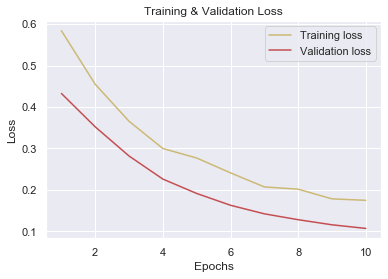

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss') 
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

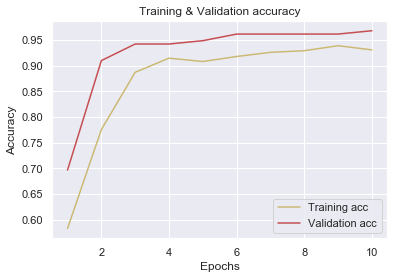

In [47]:
plt.clf() #그래프 초기화하기
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc') 
plt.plot(epochs, val_acc, 'r', label='Validation acc') 
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [48]:
import itertools
# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
undersample_fraud_predictions = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


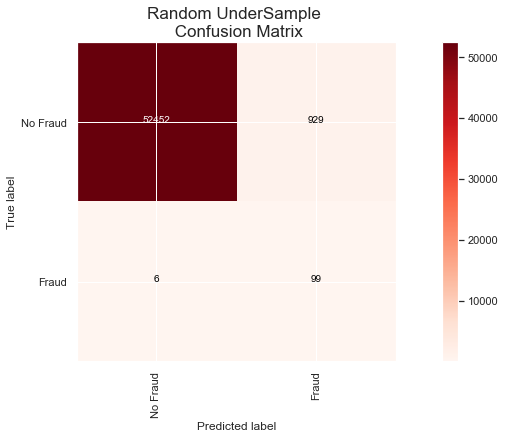

In [50]:
undersample_cm = confusion_matrix(y_test, undersample_fraud_predictions)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(13,6))
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

In [51]:
roc_auc_score(y_test,undersample_fraud_predictions,average='macro')

0.9627269734817364

## 2. 오버 샘플링에서 모델링

In [52]:
df_over = df_copy

In [53]:
#훈련, 테스트 데이터 나누기(7:3)
X=df_over.drop(['Class'],axis=1)
y=df_over['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=10)

print(X_train.shape)
print(X_test.shape)

(213943, 30)
(53486, 30)


In [54]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (213943, 30) (213943,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (427094, 30) (427094,)
SMOTE 적용 후 레이블 값 분포: 
 1    213547
0    213547
Name: Class, dtype: int64


In [55]:
dt2 = pd.concat([X_train_over,y_train_over],axis=1)
df_over = dt2.sample(len(dt2)).reset_index(drop=True)
df_over

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,scaler_amount,rob_Time,Class
0,-1.263741,2.214427,-3.150293,2.100071,0.613240,-1.900459,-0.585863,-0.246818,-1.730000,-2.724503,...,0.761851,0.059043,-0.261111,-0.426835,-0.438092,0.571798,0.411627,-0.219343,0.918445,1
1,-0.894757,0.902752,0.157064,-1.461818,0.468511,0.092881,0.100389,0.640745,0.096933,-1.501749,...,0.861652,-0.156786,0.139535,-0.393529,0.337009,-0.112963,0.121339,-0.273268,0.913016,0
2,-14.906318,6.955964,-18.326661,11.221378,-5.431998,-2.787559,-15.777790,-1.106288,-6.983382,-13.902392,...,0.522311,-2.060399,-0.894578,0.546724,0.783897,2.499306,-1.079416,-0.349231,-0.777230,1
3,-1.343915,2.486806,-0.666106,4.512272,0.077555,0.103115,0.008053,1.130809,-2.919924,1.415100,...,0.623153,0.052563,0.112320,-0.466371,0.343997,-0.168170,0.011045,-0.349231,0.717466,0
4,-0.901317,3.014035,-5.252978,3.156155,-0.852698,-2.339562,-2.193165,0.654530,-2.828663,-5.957475,...,0.085376,-0.194862,-0.361414,0.552058,0.607427,0.701248,0.354584,-0.023374,0.680204,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427089,-2.244514,1.785094,-0.421661,2.249912,-0.787574,-0.164200,0.413499,-0.414937,-0.307649,-1.628627,...,-0.868877,0.143420,-0.073271,-0.141767,-0.544522,0.070993,-0.145520,0.538026,-0.908271,1
427090,0.706237,2.925989,-5.835309,5.901911,0.362335,-1.041420,-2.802091,0.726986,-2.667190,-4.627660,...,-0.908053,-0.044837,-0.805963,0.346400,-0.008788,0.789163,0.405129,-0.339688,0.556525,1
427091,-0.404184,0.785845,0.709725,-0.612580,0.703825,-1.099587,1.094726,-0.340571,-0.434312,-0.661131,...,-0.588826,0.046757,0.076894,0.039458,0.195505,-0.162924,-0.011089,-0.348072,0.766621,0
427092,-0.175293,1.401570,-0.893163,2.003177,1.900909,-0.599097,0.460746,0.076704,-0.441369,-2.215418,...,-0.709520,-0.249411,-1.061419,0.315385,-0.173653,0.111880,0.103889,-0.349231,-0.088485,1


In [56]:
#훈련, 검증 데이터 나누기(8:2)
X=df_over.drop(['Class'],axis=1)
y=df_over['Class']

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.20,random_state=10,shuffle=True)

print(X_train.shape)
print(X_val.shape)

(341675, 30)
(85419, 30)


In [57]:
#로지스틱 회귀
lr = LogisticRegression(random_state =1,C=1000)
modeling(lr,X_train,X_val,y_train,y_val)

정확도 : 0.96, 정밀도 : 0.98, 재현율 : 0.95
f1-score : 0.96, auc : 0.963


In [58]:
#랜덤포레스트
rfc = RandomForestClassifier(n_estimators=200,random_state=30, max_depth=10,n_jobs=-1)
modeling(rfc,X_train,X_val,y_train,y_val)

정확도 : 0.99, 정밀도 : 1.00, 재현율 : 0.98
f1-score : 0.99, auc : 0.988


In [59]:
#xgb
xgb = XGBClassifier()
modeling(xgb,X_train,X_val,y_train,y_val)

정확도 : 1.00, 정밀도 : 1.00, 재현율 : 1.00
f1-score : 1.00, auc : 1.000


In [60]:
lgb = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
modeling(lgb,X_train,X_val,y_train,y_val)

정확도 : 1.00, 정밀도 : 1.00, 재현율 : 1.00
f1-score : 1.00, auc : 1.000


### 오버 샘플링 테스트 데이터 정확도 확인

In [61]:
#로지스틱 회귀
lr = LogisticRegression(random_state =1,C=1000)
modeling(lr,X_train,X_test,y_train,y_test)

정확도 : 0.98, 정밀도 : 0.07, 재현율 : 0.94
f1-score : 0.14, auc : 0.958


In [62]:
#랜덤포레스트
rfc = RandomForestClassifier(n_estimators=200,random_state=30, max_depth=8,n_jobs=-1)
modeling(rfc,X_train,X_test,y_train,y_test)

정확도 : 1.00, 정밀도 : 0.89, 재현율 : 0.91
f1-score : 0.90, auc : 0.953


In [63]:
#xgb
xgb = XGBClassifier()
modeling(xgb,X_train,X_test,y_train,y_test)

정확도 : 1.00, 정밀도 : 0.85, 재현율 : 0.91
f1-score : 0.88, auc : 0.953


In [64]:
#lgbm
lgb = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
modeling(lgb,X_train,X_test,y_train,y_test)

정확도 : 1.00, 정밀도 : 0.94, 재현율 : 0.89
f1-score : 0.91, auc : 0.943


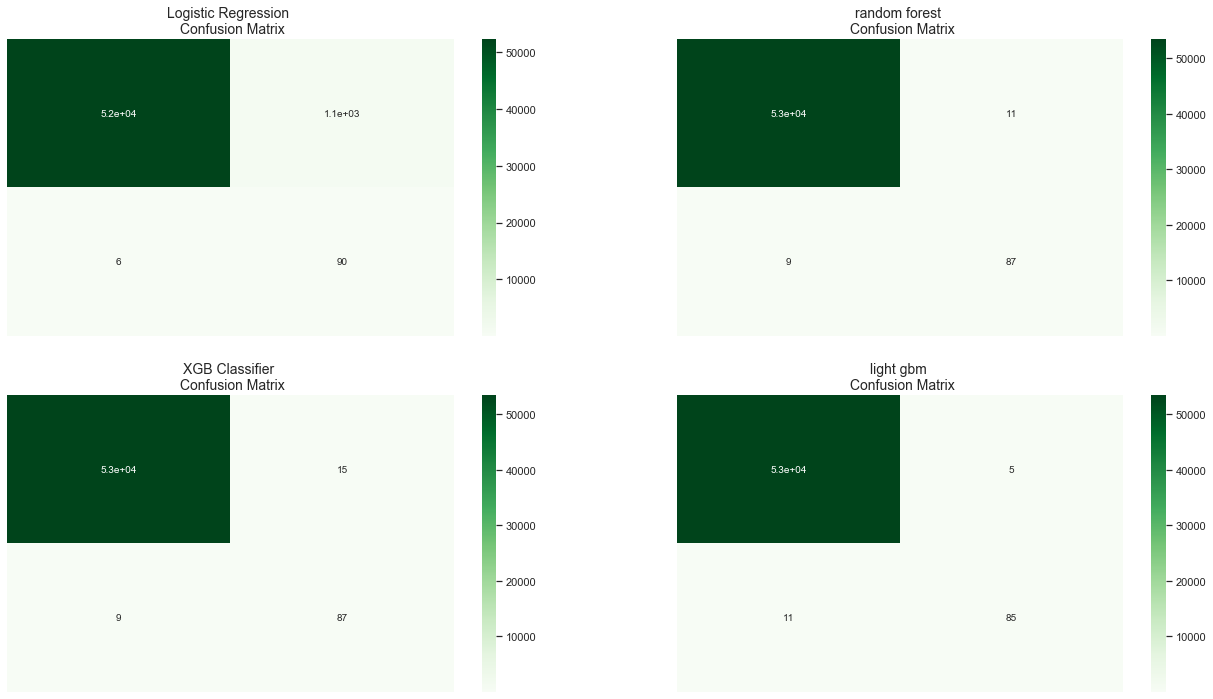

In [65]:
#히트맵 그리기
y_pred_log_reg = lr.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_lgb = lgb.predict(X_test)


lr = confusion_matrix(y_test, y_pred_log_reg)
rfc = confusion_matrix(y_test, y_pred_rfc)
xgb = confusion_matrix(y_test, y_pred_xgb)
lgb = confusion_matrix(y_test, y_pred_lgb)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(lr, ax=ax[0][0], annot=True, cmap=plt.cm.Greens)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=30, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=30, rotation=360)

sns.heatmap(rfc, ax=ax[0][1], annot=True, cmap=plt.cm.Greens)
ax[0][1].set_title("random forest \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=30, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=30, rotation=360)

sns.heatmap(xgb, ax=ax[1][0], annot=True, cmap=plt.cm.Greens)
ax[1][0].set_title("XGB Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=30, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=30, rotation=360)

sns.heatmap(lgb, ax=ax[1][1], annot=True, cmap=plt.cm.Greens)
ax[1][1].set_title("light gbm \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=30, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=30, rotation=360)

plt.show()

## 오버 샘플링 신경망

In [66]:
import keras
from keras import backend as K
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import binary_crossentropy
from keras.models import *
from keras.layers import *

model = Sequential()
model.add(Dense(12, input_shape=(30, ), activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))
optimizer = Adam()
model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 13        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [68]:
history=model.fit(X_train,y_train,epochs=10,batch_size=5,validation_data=(X_val,y_val))

Epoch 1/10
68335/68335 [==============================] - 183s 3ms/step - loss: 0.0360 - accuracy: 0.9865 - val_loss: 0.0123 - val_accuracy: 0.9963
Epoch 2/10
68335/68335 [==============================] - 169s 2ms/step - loss: 0.0131 - accuracy: 0.9962 - val_loss: 0.0094 - val_accuracy: 0.9974
Epoch 3/10
68335/68335 [==============================] - 180s 3ms/step - loss: 0.0103 - accuracy: 0.9972 - val_loss: 0.0087 - val_accuracy: 0.9975
Epoch 4/10
68335/68335 [==============================] - 198s 3ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.0059 - val_accuracy: 0.9986
Epoch 5/10
68335/68335 [==============================] - 209s 3ms/step - loss: 0.0081 - accuracy: 0.9980 - val_loss: 0.0091 - val_accuracy: 0.9978
Epoch 6/10
68335/68335 [==============================] - 219s 3ms/step - loss: 0.0075 - accuracy: 0.9981 - val_loss: 0.0055 - val_accuracy: 0.9985
Epoch 7/10
68335/68335 [==============================] - 219s 3ms/step - loss: 0.0068 - accuracy: 0.9984 - val_

In [69]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1672/1672 [==============================] - 4s 3ms/step - loss: 0.0355 - accuracy: 0.9975

 테스트 정확도: 0.9975


In [70]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

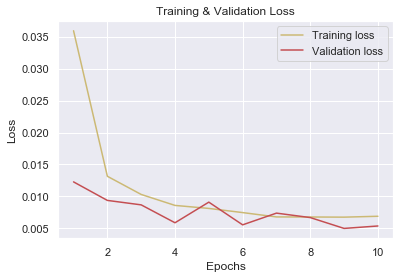

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss') 
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

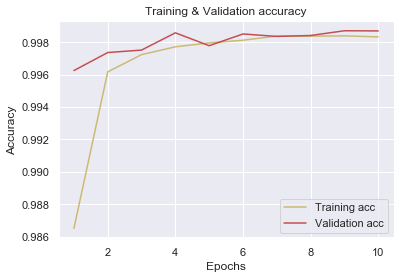

In [73]:
plt.clf() #그래프 초기화하기
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc') 
plt.plot(epochs, val_acc, 'r', label='Validation acc') 
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [74]:
oversample_fraud_predictions = model.predict_classes(X_test)

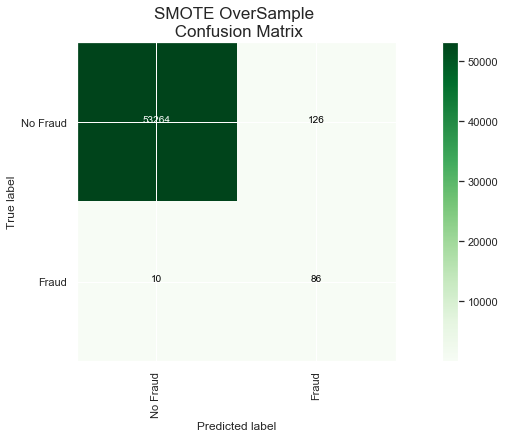

In [75]:
oversample_cm = confusion_matrix(y_test, oversample_fraud_predictions)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(13,6))
plot_confusion_matrix(oversample_cm, labels, title="SMOTE OverSample \n Confusion Matrix", cmap=plt.cm.Greens)

In [76]:
roc_auc_score(y_test,oversample_fraud_predictions,average='macro')

0.9467366704126866